In [1]:
import pickle
import random

import torch
from transformers import Blip2Processor

from lib.easy_vqa.easyvqa_classification import EasyVQAClassification
from lib.models.feature_visualizer import FeatureVisualizer
from lib.trainers.classification_trainer import ClassificationTrainer
from lib.types import (
    DatasetTypes,
    HFRepos,
    ModelTypes,
    Suffix,
    TrainingParameters,
    VQAParameters,
)
from lib.utils import EXPERIMENT
from lib.visualization import (
    display_class_specific_images,
    show_image,
)

%load_ext autoreload
%autoreload 2

# Load dependencies
processor = Blip2Processor.from_pretrained(HFRepos.BLIP2_OPT)

DIR = "analysis/easyvqa/"
EXPERIMENT.set_seed(2024).apply_seed()

/home/atomwalk12/anaconda3/envs/dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:lib.experiments:Setting self.seed=2024


# Results for EasyVQA

In [12]:
args = VQAParameters(Suffix.Train)  # using combined dataset
args.processor = processor
dataset = EasyVQAClassification(args)

INFO:lib.dataset_base:Loaded 10846 items from /home/atomwalk12/Dropbox (Old)/notes/vision/project/BeyondVisionQA/VisualQA/data/easy-vqa/classification/train.pkl


In [4]:
split = "train"

best_path = f"data/models/easy_vqa/classifier/1780639714/features_{split}.pkl"  # classifier outputs
data = pickle.load(open(best_path, "rb"))
features = data["features"]
labels = data["labels"]


feature_visualizer = FeatureVisualizer(
    id_to_answer=dataset.id_to_answer, dataset_name="easyvqa"
)
feature_visualizer.set_features(features, labels, split)
feature_visualizer.visualize_features_with_umap(
    save_path=f"{DIR}/5.easyvqa_{split}_1780639714_features"
)

/home/atomwalk12/anaconda3/envs/dev/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/home/a

In [11]:
args = VQAParameters(Suffix.Val)  # using combined dataset
args.processor = processor
dataset = EasyVQAClassification(args)

split = "val"
best_path = f"data/models/easy_vqa/classifier/1780639714/features_{split}.pkl"  # classifier outputs
data = pickle.load(open(best_path, "rb"))
features = data["features"]
labels = data["labels"]


feature_visualizer = FeatureVisualizer(
    id_to_answer=dataset.id_to_answer, dataset_name="easyvqa"
)
feature_visualizer.set_features(features, labels, split)
feature_visualizer.visualize_features_with_umap(
    save_path=f"{DIR}/5.easyvqa_{split}_features"
)

INFO:lib.dataset_base:Loaded 2712 items from /home/atomwalk12/Dropbox (Old)/notes/vision/project/BeyondVisionQA/VisualQA/data/easy-vqa/classification/val.pkl
/home/atomwalk12/anaconda3/envs/dev/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have f

# Comparing classes side by side


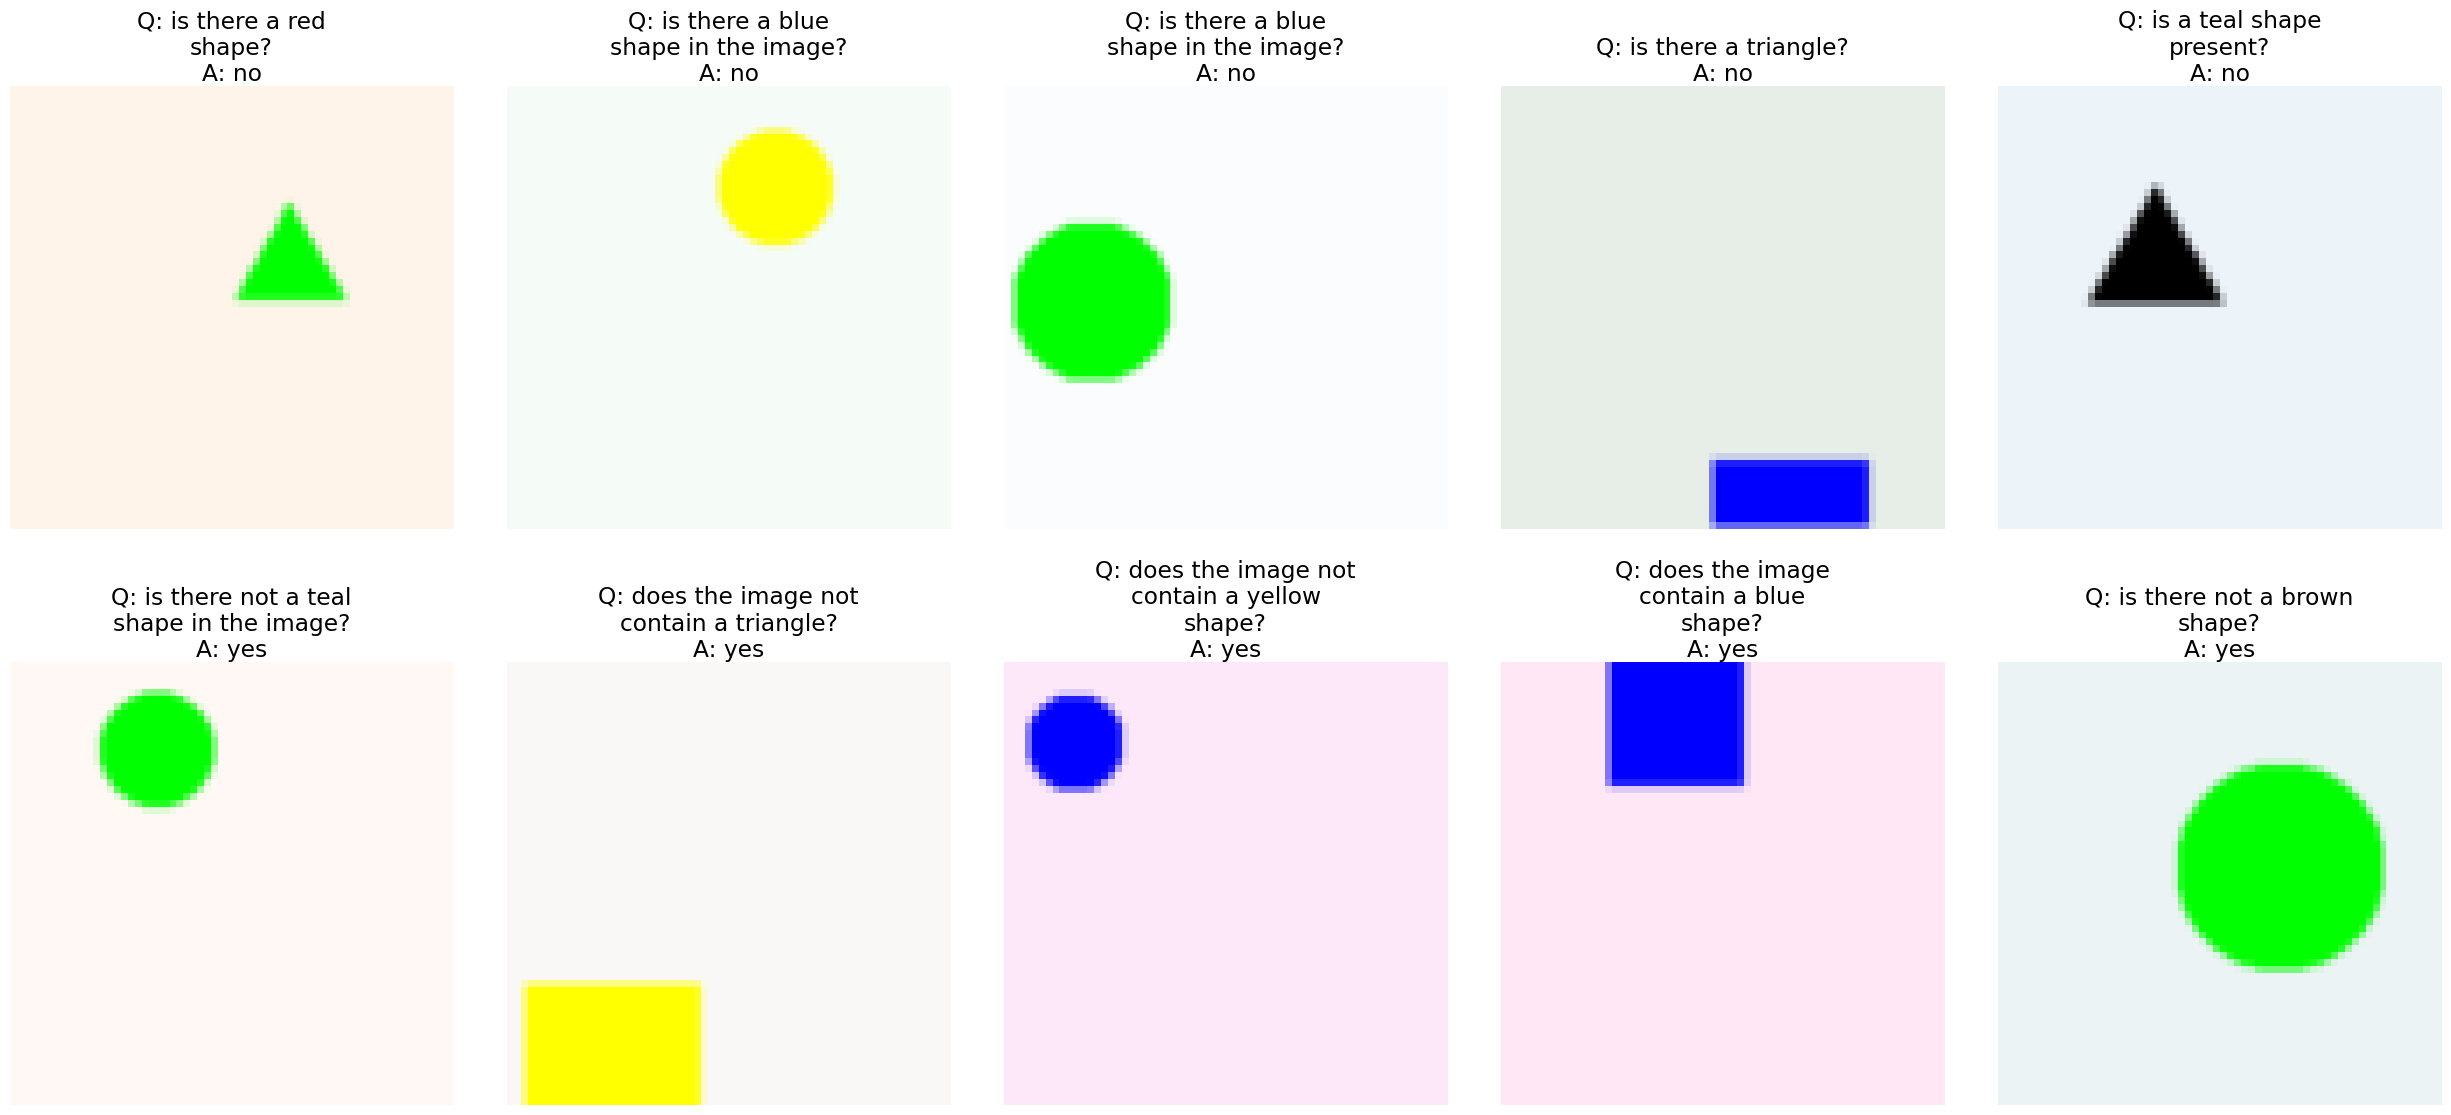

Class-specific sample images saved as analysis/easyvqa//7.easyvqa_class_specific_samples.pdf


In [6]:
class_types = ["no", "yes"]  # Example class types
display_class_specific_images(
    dataset.raw_dataset,
    "EasyVQA",
    f"{DIR}/7.easyvqa_class_specific_samples.pdf",
    class_types,
    font_size=24,
)

# Live evaluation

This section allows to randomly choose images from the dataset and predict the answer.


In [2]:
EXPERIMENT.set_seed(2024).apply_seed()

test_args = VQAParameters(split="test", is_testing=True, use_proportional_split=True)
test_args.processor = processor

dataset = EasyVQAClassification(test_args)

parameters = TrainingParameters(
    dataset_name=DatasetTypes.EASY_VQA,
    resume_checkpoint=True,
    model_name=ModelTypes.BLIP2Classifier,
    is_trainable=False,
    train_args=None,
    val_args=None,
    test_args=test_args,
    resume_state=False,
    is_testing=True,
    use_wandb=False,
)

module = ClassificationTrainer(parameters)
model = module.model
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INFO:lib.experiments:Setting self.seed=2024
INFO:lib.dataset_base:Loaded 3347 items from /home/atomwalk12/Dropbox (Old)/notes/vision/project/BeyondVisionQA/VisualQA/data/easy-vqa/classification/test.pkl
INFO:lib.trainers.base_trainer:LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=None, inference_mode=False, r=8, target_modules='all-linear', lora_alpha=8, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights='gaussian', layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))
INFO:lib.trainers.base_trainer:BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float32",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_q

[INFO] Using GPU: NVIDIA GeForce RTX 4090



`low_cpu_mem_usage` was None, now default to True since model is quantized.
INFO:lib.models.blip2_classifier_experiment5:config.interm_dim=1024


trainable params: 0 || all params: 1,181,823,762 || trainable%: 0.0000


/home/atomwalk12/Dropbox (Old)/notes/vision/project/BeyondVisionQA/VisualQA/lib/models/base_classifier.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.classifier

no no


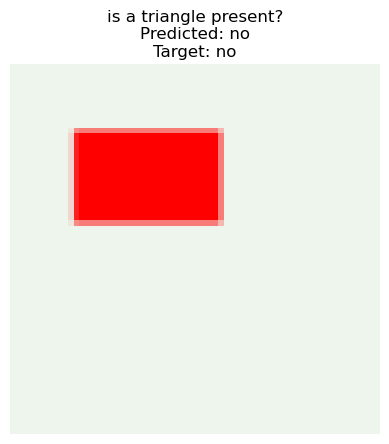

In [27]:
sample = random.randint(0, len(dataset))
data = dataset[sample]

pixel_values = data["pixel_values"].unsqueeze(0).to(device)
input_ids = data["input_ids"].unsqueeze(0).to(device)
attention_mask = data["attention_mask"].unsqueeze(0).to(device)
labels = data["labels"].unsqueeze(0).to(device)

outputs = model(
    pixel_values=pixel_values,
    input_ids=input_ids,
    attention_mask=attention_mask,
    labels=labels,
    log=False,
)
_, preds = torch.max(outputs.logits, 1)
_, target_pred = torch.max(labels, 1)

predicted = dataset.id_to_answer[preds.item()]
target = dataset.id_to_answer[target_pred.item()]

print(predicted, target)
show_image(dataset.raw_dataset[sample], predicted, target)